In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
# Use if you have jupyter matplotlib installed. Makes 3D graphs interactive.
# https://github.com/matplotlib/ipympl
%matplotlib widget

In [2]:
import pickle
import os

import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import numpy as np

In [3]:
base_dir = "/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp"

import dataloading

# rsync command:
# rsync --ignore-existing --progress -avhze ssh Franka_TeleOp gsk6me@rivanna.hpc.virginia.edu:/project/CollabRoboGroup/gsk6me/real_frankadata

df = dataloading.get_demonstrations_index(base_dir)
df

,Participant,Task,Interface,Trial
0,1,1,2,1
1,1,1,3,1
2,1,3,1,1
3,1,3,2,1
4,1,3,3,2
...,...,...,...,...
411,34,6,1,1
412,34,6,2,1
413,34,6,3,1
414,34,8,1,1


In [4]:
# Find VR examples
all_data = []
successful_rows = []
vr_df = df[df['Interface'] == 3]

for i, row in vr_df.iterrows():
    participant_id, task_id, _, trial_id = row
    
    try:
        all_data.append(dataloading.get_vr_data(base_dir, participant_id, task_id, trial_id))
    except AssertionError:
        print("Missing:", row)
        continue
        
    successful_rows.append(row)


Missing: Participant    2
Task           3
Interface      3
Trial          1
Name: 19, dtype: int64
Missing: Participant    13
Task            3
Interface       3
Trial           1
Name: 95, dtype: int64
Missing: Participant    13
Task            5
Interface       3
Trial           1
Name: 98, dtype: int64
Missing: Participant    22
Task            2
Interface       3
Trial           1
Name: 216, dtype: int64


[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 152, 158, 163, 168, 175, 182, 188, 193, 198, 203, 209, 220, 226, 232, 237, 244, 249, 254, 262, 267, 272, 279, 284, 289, 294, 299, 304, 309, 314, 323, 328, 333, 343, 348, 353, 358, 363, 370, 375, 381, 386, 391, 400, 405, 411, 416, 421, 426, 431, 439, 444, 449, 454, 464, 469, 474, 484, 489, 494, 502, 507, 515, 520, 525, 530, 540, 545, 554, 559, 567, 572, 577, 582, 593, 598, 603, 608, 611]


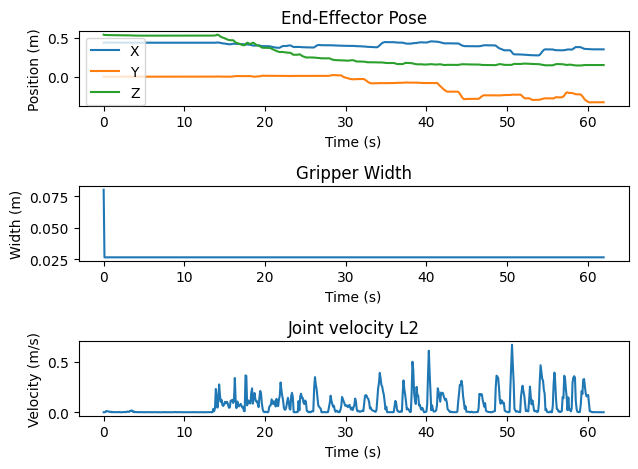

In [5]:
import matplotlib.pyplot as plt
from detect_keypoints import find_keypoints

result = dataloading.collate_observations(all_data[15])
keypoints = find_keypoints(result)
# Will need a better keypoint detection method, or some other way to encode motion plans.
print(keypoints)

dataloading.plot_demonstration(result)

In [6]:
# Group observations by Task ID
for task_id, indices in vr_df.groupby('Task').groups.items():
    print(f"Task ID {task_id}: {indices.tolist()}")
    
for i, row in enumerate(successful_rows):
    if row.name == 59:
        print(i)

Task ID 1: [1, 14, 30, 44, 59, 73, 74, 90, 104, 117, 131, 143, 157, 171, 186, 262]
Task ID 2: [216, 230, 248, 282, 296, 314, 331, 345, 362, 378, 393, 406]
Task ID 3: [4, 18, 19, 34, 49, 62, 63, 77, 94, 95, 107, 121, 134, 146, 161, 191, 192, 206]
Task ID 4: [219, 220, 233, 252, 268, 269, 270, 286, 299, 300, 301, 317, 335, 349, 350, 365, 366, 382, 383, 397, 409]
Task ID 5: [22, 23, 37, 52, 66, 81, 82, 97, 98, 110, 125, 137, 150, 164, 178, 196, 209]
Task ID 6: [223, 236, 256, 257, 275, 289, 305, 322, 323, 339, 355, 356, 357, 369, 386, 401, 413]
Task ID 7: [27, 41, 55, 70, 87, 101, 113, 128, 140, 154, 167, 181, 199, 200, 212]
Task ID 8: [226, 239, 261, 279, 292, 310, 327, 342, 374, 390, 404]
Task ID 10: [243]
15


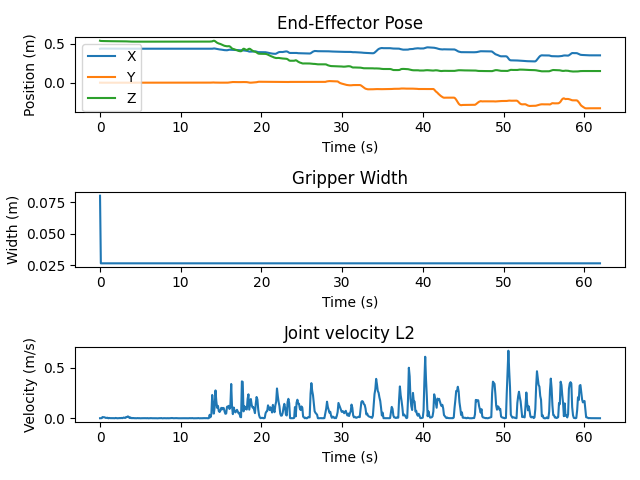

In [79]:
plt.clf()
dataloading.plot_demonstration(dataloading.collate_observations(all_data[15]))

Timestamp 0 corresponds to observation #1; max=1723


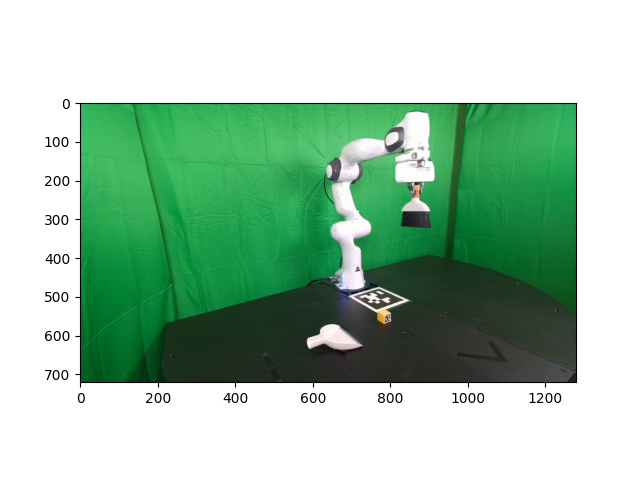

In [44]:
data_id = 15
target_timestamp = 0

participant_id, task_id, interface_id, trial_id = successful_rows[data_id]
obs = dataloading.get_observations(base_dir, participant_id, task_id, interface_id, trial_id)

robot_states = dataloading.collate_observations(all_data[data_id])
control_index = np.where((np.array(robot_states['timestamp']) - robot_states['timestamp'][0]) > target_timestamp)[0][0]

observation_timestamps = np.array(obs['data']['kinect1']['timestamps'])
observation_timestamps = observation_timestamps - obs['data']['kinect1']['timestamps'][0]
for observation_pointer in range(len(observation_timestamps)):
    if ts[observation_pointer] > target_timestamp:
        break

print(f"Timestamp {target_timestamp} corresponds to observation #{observation_pointer}; max={len(observation_timestamps)}")

image_path = os.path.join(obs['root'], "kinect1_color", obs['data']['kinect1']['color_image_paths'][kinect_index])
image = PIL.Image.open(image_path)
plt.clf()
plt.imshow(np.array(image))
plt.show()

## Camera Calibration

We will now attempt to calculate camera extrinsic matrices based on AprilTags and/or measured positions.

In [26]:
%matplotlib widget

::: Current Information :::
Displayed timestamp [robot state]: 0
Corresponding robot state index: 1
Corresponding observation index: 0
::: AprilTag-Based Calibration :::
rvec: [[ 1.67476645]
 [ 0.90432977]
 [-0.75803163]]
tvec: [[0.20679504]
 [0.35860936]
 [1.26462939]]
[[960.58075896 316.4095944 ]
 [961.84612024 318.52271039]
 [961.84585245 318.52223988]
 ...
 [717.9701694  560.42103697]
 [717.97339278 560.42079045]
 [717.97295    560.42021581]]
::: IMU for displayed timestamp :::
end-effector pose: [0.436189204454422, -0.0005233812262304127, 0.5337942838668823]


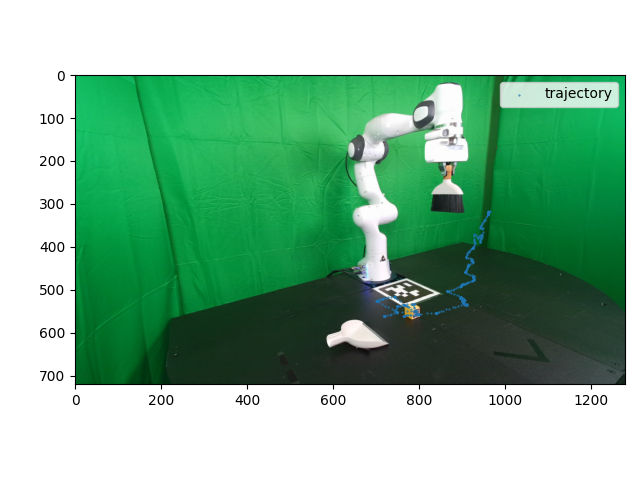

In [111]:
from apriltag import apriltag
import cv2

from camera_calibration import \
    left_camera_intrinsic_matrix, left_camera_dist_coeffs, \
    right_camera_intrinsic_matrix, right_camera_dist_coeffs

# These are world coordinates (meters).
# X points away from the robot.
# Y points to the right, when X is facing you.
# Z points up.
# The AprilTag is 7in x 7in.
apriltag_z = 0 # -0.20
apriltag_size = 0.1778
apriltag_x = 0 # 0.15
apriltag_y = 0
apriltag_object_points = np.array([
    # order: left bottom, right bottom, right top, left top
    [apriltag_size, -apriltag_size/2, apriltag_z],
    [apriltag_size,  apriltag_size/2, apriltag_z],
    [            0,  apriltag_size/2, apriltag_z],
    [            0, -apriltag_size/2, apriltag_z],
]).astype(np.float32)

apriltag_object_points[:, 0] += apriltag_x
apriltag_object_points[:, 1] += apriltag_y

demo_cube_object_points = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 0, 1],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
]).astype(np.float32)

normalization_delay = 2.1
displayed_timestamp = 0

robot_states = dataloading.collate_observations(all_data[data_id])
robot_state_index = np.where((np.array(robot_states['timestamp']) - robot_states['timestamp'][0]) > displayed_timestamp)[0][0]

observation_timestamps = np.array(obs['data']['kinect1']['timestamps'])
observation_timestamps = observation_timestamps - observation_timestamps[0] + normalization_delay
for observation_index in range(len(observation_timestamps)):
    if observation_timestamps[observation_index] > displayed_timestamp:
        break
        
observation_timestamps_2 = np.array(obs['data']['kinect2']['timestamps'])
observation_timestamps_2 = observation_timestamps_2 - observation_timestamps_2[0] + normalization_delay
for observation_index_2 in range(len(observation_timestamps_2)):
    if observation_timestamps[observation_index_2] > displayed_timestamp:
        break

INDEX = observation_index
INDEX2 = observation_index_2

image_path = os.path.join(obs['root'], "kinect1_color", obs['data']['kinect1']['color_image_paths'][INDEX])
image = PIL.Image.open(image_path)

image_path_2 = os.path.join(obs['root'], "kinect2_color", obs['data']['kinect2']['color_image_paths'][INDEX2])
image_2 = PIL.Image.open(image_path_2)

print("::: Current Information :::")
print("Displayed timestamp [robot state]:", displayed_timestamp)
print("Corresponding robot state index:", robot_state_index)
print("Corresponding observation index [1]:", observation_index)
print("Corresponding observation index [2]:", observation_index_2)

# try creating extrinsic matrix
import numpy as np

detector = apriltag("tag36h11")

image_array = np.array(image)
image_gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
apriltag_image_points = detector.detect(image_gray)[0]['lb-rb-rt-lt']

image_array_2 = np.array(image_2)
image_gray_2 = cv2.cvtColor(image_array_2, cv2.COLOR_RGB2GRAY)
apriltag_image_points2 = detector.detect(image_gray_2)[0]['lb-rb-rt-lt']

# for i, detection in enumerate(detections):
#     apriltag_image_points = detection['lb-rb-rt-lt']
#     x, y = apriltag_image_points.T
#     plt.scatter(x, y, label='tag ' + str(i + 1))

use_trajectory_calibration = False

plt.clf()
plt.subplots(1, 1, 1)
plt.imshow(image_array)
        
ret, rvec, tvec = cv2.solvePnP(apriltag_object_points, apriltag_image_points, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
print("::: AprilTag-Based Calibration :::")
print("rvec:", rvec)
print("tvec:", tvec)

# cube_image_points, _jacobian = cv2.projectPoints(demo_cube_object_points, rvec, tvec, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
# cube_image_points = cube_image_points[:, 0, :]
# plt.scatter(*cube_image_points.T, label='tag ' + str(i + 1) + ' cube points')

# Plot the time series for the run
# trajectory_image_points, _jacobian = cv2.projectPoints(robot_states['ee_pos'] * 4.5 + np.array([0.05, 0.05, 1.6]), rvec, tvec, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
trajectory_image_points, _jacobian = cv2.projectPoints(robot_states['ee_pos'], rvec, tvec, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
trajectory_image_points = trajectory_image_points[:, 0, :]
plt.scatter(*trajectory_image_points.T, label='trajectory', s=0.2)
print(trajectory_image_points)

print("::: IMU for displayed timestamp :::")
print("end-effector pose:", list(robot_states['ee_pos'][robot_state_index]))

plt.legend()
plt.show()

In [ ]:
if use_trajectory_calibration:
    """
    Indices: [start === 0, 500, 700, 1200, 1400, end === -1]
    """
    measured_object_points = np.array([
        # start
        [0.4360732436180115, -0.0005260216421447694, 0.5303716063499451],
        # 30s
        [0.39455023407936096, -0.014536830596625805, 0.20577460527420044],
        # 35s
        [0.44221994280815125, -0.0829448476433754, 0.17535479366779327],
        # 40s
        [0.4379996955394745, -0.0806502029299736, 0.15570494532585144],
        # 50s
        [0.3377264440059662, -0.2345484048128128, 0.1508406698703766],
        # 55s
        [0.349152535200119, -0.277385413646698, 0.14560042321681976],
        # 60s
        [0.35128340125083923, -0.3221738636493683, 0.1490202248096466],
        # 70s

        
        # [0.37399399, 0.00955128, 0.24610548],
        # [0.34978241, -0.32743371, 0.14896235],
        # [ 0.42864648, -0.16139126, 0.15062304],
        # [0.34978241, -0.32743371, 0.14896235],
    ])
    image_points = np.array([
        # start
        [882, 148],
        # 30s
        [860, 420],
        # 35s
        [864, 267],
        # 40s
        [861, 412],
        # 50s
        [863, 410],
        # 55s
        [700, 436],
        # 60s
        [720, 431],
    ]).astype(np.float32)

    ret, rvec, tvec = cv2.solvePnP(measured_object_points, image_points, left_camera_intrinsic_matrix, left_camera_dist_coeffs)
    print("::: Trajectory-Based Calibration :::")
    print("rvec.T:", rvec.T)
    print("tvec.T:", tvec.T)

In [108]:
# Try generating a video instead

import cv2
import tqdm

fps = 20

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output.mp4', fourcc, fps, (1280, 720))

data_id = 15
robot_states = dataloading.collate_observations(all_data[data_id])
participant_id, task_id, interface_id, trial_id = successful_rows[data_id]
obs = dataloading.get_observations(base_dir, participant_id, task_id, interface_id, trial_id)

prev_written_timestamp = -1

# Plot the predicted end-effector position as well

robot_state_index = 0

# normalize both according to self
observation_timestamps = obs['data']['kinect1']['timestamps']
observation_timestamps = np.array(observation_timestamps) - observation_timestamps[0] + normalization_delay
observation_paths = obs['data']['kinect1']['color_image_paths']
robot_state_timestamps = np.array(robot_states['timestamp'])
robot_state_timestamps -= robot_state_timestamps[0]

for timestamp, path in tqdm.tqdm(zip(observation_timestamps, observation_paths), desc='Generating video...', total=len(observation_timestamps)):
    if timestamp - prev_written_timestamp >= 1/fps:
        prev_written_timestamp = timestamp
        image_path = os.path.join(obs['root'], "kinect1_color", path)
        image = PIL.Image.open(image_path)
        image_np = np.array(image)
        
        # Get closest observation: o(n) overall, as observation_index is monotonically increasing.
        while robot_state_index < len(robot_state_timestamps) and robot_state_timestamps[robot_state_index] < timestamp:
            robot_state_index += 1

        # Draw only if we still have a trajectory to show.
        if robot_state_index < len(robot_state_timestamps):
            traj_x, traj_y = trajectory_image_points[robot_state_index].astype(int)
            cv2.circle(image_np, (traj_x, traj_y), 5, (0, 255, 0), 3)

        output_video.write(image_np)

output_video.release()

Generating video...: 100%|██████████| 1723/1723 [00:21<00:00, 80.69it/s]


In [110]:
!rm output_fixed.mp4
!ffmpeg -i output.mp4 output_fixed.mp4 > /dev/null 2>&1
# from IPython.display import Video
Video("output_fixed.mp4")

rm: cannot remove 'output_fixed.mp4': No such file or directory


In [135]:
import numpy as np
import json

demo_index = 0

mask = []

while demo_index < len(df):
    try:
        participant_id, task_id, inferface_id, trial_id = df.iloc[demo_index]

        data = get_teleoperation_index(base_dir, participant_id, task_id, interface_id, trial_id)
        
        t = [d['unix_time_stamp'] for d in data]
        x = [d['eef_pos']['x'] for d in data]
        y = [d['eef_pos']['y'] for d in data]
        z = [d['eef_pos']['z'] for d in data]
        t = np.array(t) - t[0]
        
        # t = data['unix_time_stamp'].to_numpy()
        # t = t - t[0]
        # eef = [json.loads(s.replace("'", "\"").lower()) for s in data['eef_pos'].tolist()]
        # x = [d['x'] for d in eef]
        # y = [d['y'] for d in eef]
        # z = [d['z'] for d in eef]

        if max(x) - min(x) == 0:
            # assume blank run
            raise ValueError("empty dataset")

        plt.title("Teleoperation data")
        plt.plot(t, x, label='X')
        plt.plot(t, y, label='Y')
        plt.plot(t, z, label='Z')
        plt.show()
        
        mask.append(True)
    except Exception as e:
        print(e)
        mask.append(False)
    
    demo_index += 1

empty dataset
empty dataset
[Errno 2] No such file or directory: '/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_1/robot_data_1_3_2_1.pkl'
[Errno 2] No such file or directory: '/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_1/robot_data_1_3_2_1.pkl'
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_3/Interface_2/Trial_2
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_5/Interface_2/Trial_2
empty dataset
empty dataset
Teleoperation folder does not exist: /project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp/Joystick_SpaceMouse_Interface/P_1/Task_7/Interface_2/Trial_2
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
empty dataset
Teleoperat

In [ ]:
base_dir = "/project/CollabRoboGroup/gsk6me/real_frankadata/Franka_TeleOp"
img = PIL.Image.open(base_dir + "/RGB_Data/P_19/Task_3/Interface_1/Trial_1/rs_color/color_frame_293_1700254934.6310108.png")
plt.imshow(img)